# Application
In this notebook, we'll be identifying multiple items in a single image. We'll do this by taking several samples frames using a sliding window and making predictions on each frame. Although this is method is not optimal (for efficiency and performance), its implementation is simple enough for the scope of this project.

More advanced deep learning architectures exist for multiple object detection which require more data annotated with bounding boxes.

We begin by importing the necessary modules and defining some runtime constants. Note that the definition of the architecture for `TransferModel` has been added to `modeldefinition.py` and is included as an import: 

In [1]:
# NumPy and pandas for manipulating data
import numpy as np
import pandas as pd

# For training diagnostics later
import matplotlib as mpl
from matplotlib import pyplot as plt

# Necessary torch modules
import torch
from torch.nn import Softmax

# Definition of the model architecture to load
from modeldefinition import TransferModel

In [2]:
ITEM_NAMES_FILE = '../database/raw/food-items.txt' # Path to food item names
MODEL_FILE = './checkpoints/model.pt' # Path to trained model

# Size of the sliding window
IMAGE_SIZE = 224
# How much to move the sliding window by for each prediction
STRIDE = 70

Now we load the model as well as the food item names:

In [3]:
# Read item names
with open(ITEM_NAMES_FILE) as f:
    item_names = f.read().splitlines()

# Count the number of items
n_classes = len(item_names)

# Make dictionaries to turn labels into indicies
label_dict_itos = dict(zip(range(0, n_classes), item_names))

# Load the model
model = torch.load(MODEL_FILE)
softmax = Softmax()

We define a function that will perform the sliding window sampling and make predictions on each frame:

In [4]:
def sample_and_predict(image, threshold=0.6):
    """Take sliding window samples from an image and make predictions on each sample.
    
    image          (np.ndarray): Image to take samples from in the form of NumPy array.
    threshold           (float): Minimum probability threshold to accept prediction as a positive.
    """
    plt.figure(figsize=(20, 16))
    
    # Figure out how many rows and columns we'll be using
    height = image.shape[0]
    width = image.shape[1]

    rows = 1 + (height - IMAGE_SIZE) // STRIDE
    cols = 1 + (width - IMAGE_SIZE) // STRIDE

    # Starting positions 
    i = 1                   # Keep track of the image number for plt.subplot 
    y_pos = 0               # Start at the top
    predictions = []        # Keep track of predictions 
    while y_pos + IMAGE_SIZE < height:
        x_pos = 0           # Start at the left
        while x_pos + IMAGE_SIZE < width:
            # Get a crop from the original image
            crop = image[y_pos:y_pos+IMAGE_SIZE, x_pos:x_pos+IMAGE_SIZE]

            # Turn it into a tensor for the model
            crop_tensor = torch.tensor([[crop[:,:,0], crop[:,:,1], crop[:,:,2]]])\
                            .type_as(torch.FloatTensor())
            # Make predictions and save them
            probs = softmax(model(crop_tensor).data).numpy()
            pred = label_dict_itos[np.argmax(probs, axis=1)[0]]
            
            # Make sure the probability is high enough to be a positive for the class.
            if probs.max() > threshold:
                predictions.append(pred)
            
            # Show the image
            plt.subplot(rows, cols, i)
            plt.imshow(crop)
            plt.title("{}\n{:.2f}".format(pred, probs.max()))
            plt.axis('off')

            # Move the window to the right
            x_pos += STRIDE
            i += 1  # next subplot
        # Move the window down
        y_pos += STRIDE

    print(set(predictions))
    return predictions

Let's use a picture that I took as an example and try to identify the food items in it:

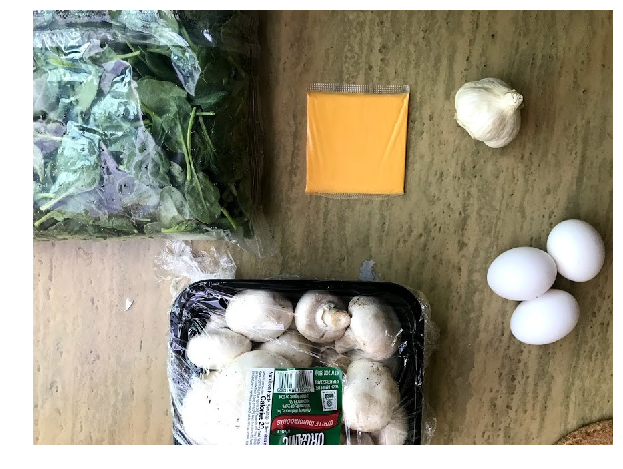

/home/jshuai/anaconda3/envs/food-identifier/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'cheddar_cheese', 'spinach', 'garlic', 'eggs', 'mushroom'}


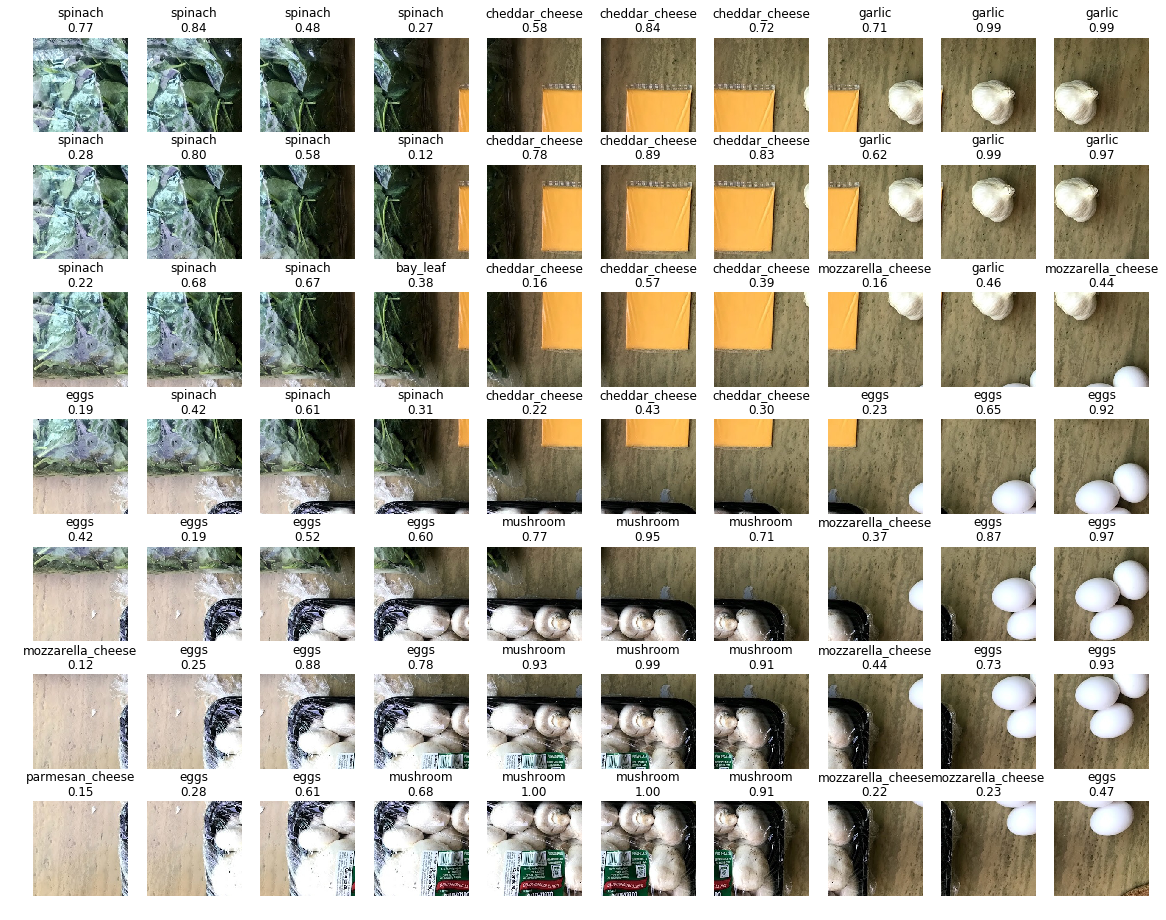

In [5]:
# Get example image
file_path = "./sample_images/example1.jpg"
image = plt.imread(file_path)

# Show image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

predictions = sample_and_predict(image)

We can see that it found most of the items, with false positives at a low probability. After applying our probability threshold, we successfully all of the items in the image with no false positives. Great!

Let's look at another example. This time, we'll be using an image I found online:

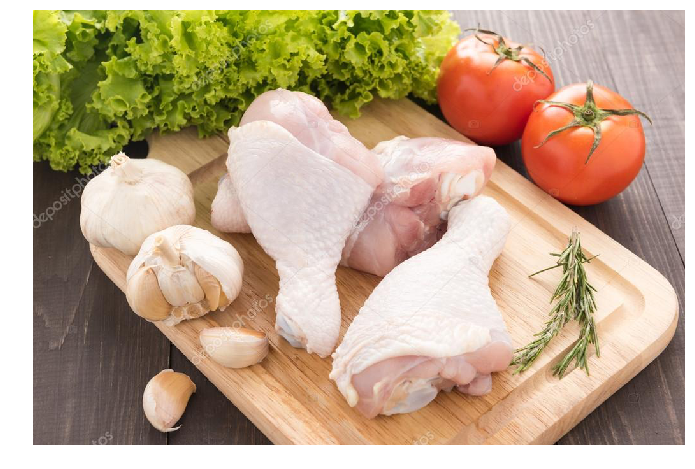

/home/jshuai/anaconda3/envs/food-identifier/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'garlic', 'lettuce', 'chicken_leg', 'rosemary', 'tomato'}


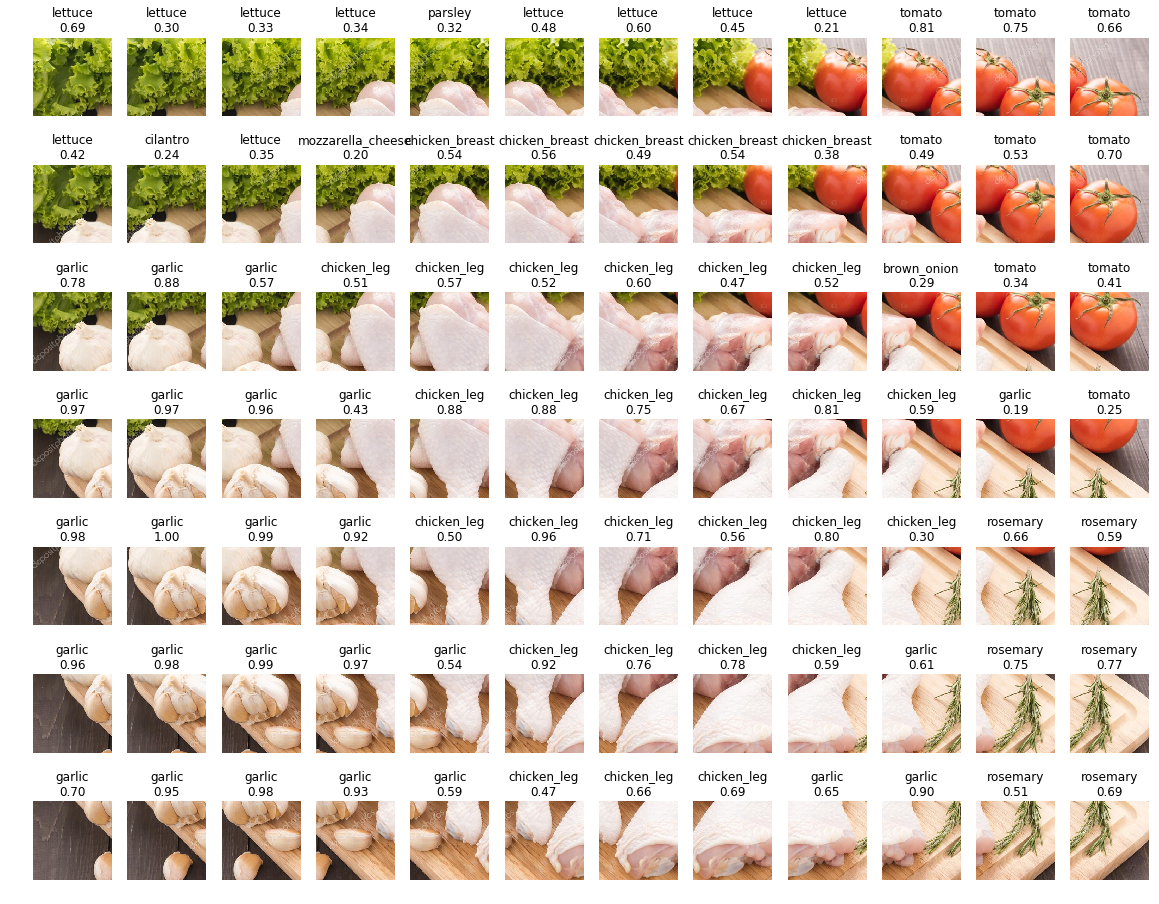

In [6]:
# Get example image
file_path = "./sample_images/example2.jpg"
image = plt.imread(file_path)

# Show image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

predictions = sample_and_predict(image)

The model found all of the ingredients once again. Let's try one more example:

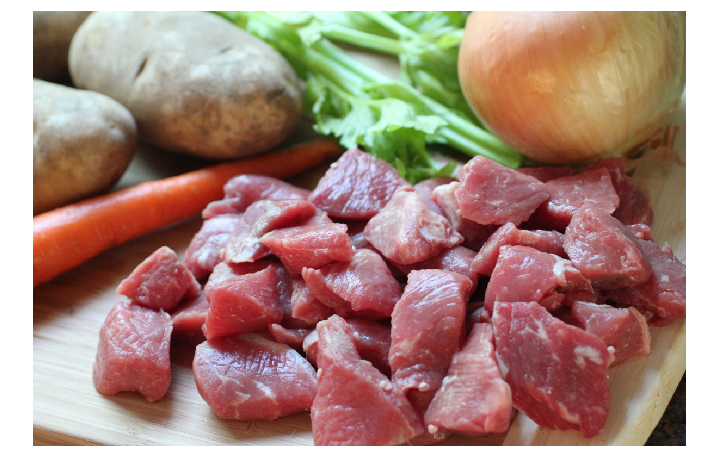

/home/jshuai/anaconda3/envs/food-identifier/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'beef', 'pork', 'celery', 'tuna', 'apples', 'potato', 'brown_onion'}


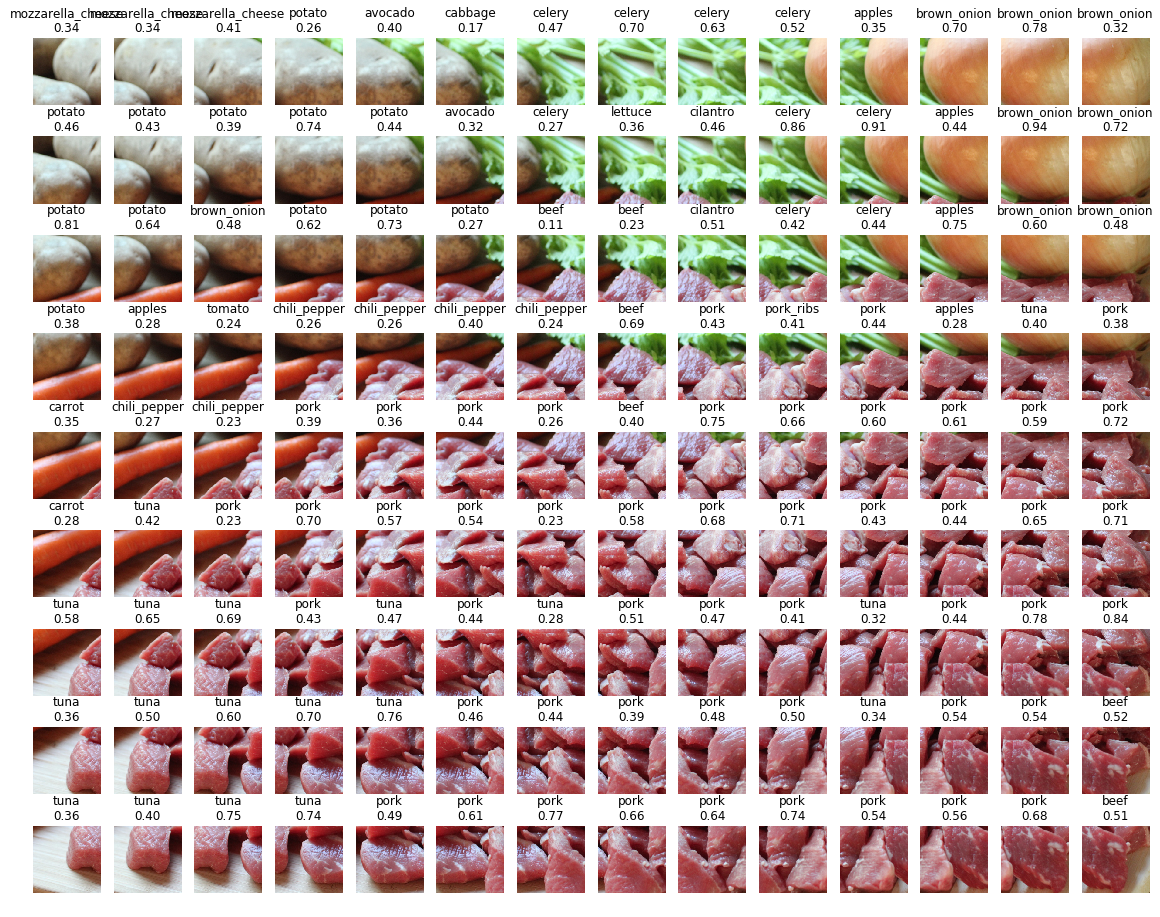

In [7]:
# Get example image
file_path = "./sample_images/example3.jpg"
image = plt.imread(file_path)

# Show image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

predictions = sample_and_predict(image)

We seem to have found extra items in this image! This is an image of beef, potatoes, celery, carrots, and onions. But the model also found tuna, pork, and apples.